In [1]:
## Imports
import pandas as pd
import numpy as np
import time
import findspark  # find spark home directory
import datetime
import sys
from os import chdir, getcwd, mkdir
from os.path import exists

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Print using Markdown style
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

    
    
# Import path to zipfile
ZIP_FILE = '/home/trangel/guobiao-v4/veh.zip'
sys.path.insert(0, ZIP_FILE)
from trip_based_stats.configs import *
import trip_based_stats.single_vin_battery_flow as bf


In [2]:
#vin = 'LMGFJ1S52H1000622'
#days = [datetime.date(2018,5,16), datetime.date(2018,5,17)]

#vin = 'LMGHP1S83H1000131'
#days = [datetime.date(2018,1,2)]
#days = [datetime.date(2017,12,26), datetime.date(2017,12,27)]
#days = [datetime.date(2018,3,10), datetime.date(2018,3,11)]

#vin = 'LMGHP1S58J1002212'
#days = [datetime.date(2018,4,29), datetime.date(2018,4,30)]

#vin = 'LMGHP1S80H1000149'
#days = [datetime.date(2018,3,29), datetime.date(2018,3,30)]

#vin = 'LMGHP1S88H1000111'
#days = [datetime.date(2017,12,16), datetime.date(2017,12,17)]

#vin = 'LMGHP1S80H1S00030'
#days = [datetime.date(2018,7,18)]


#vin = 'LMGHP1S83H1000131'
#days = [datetime.date(2018,4,14), datetime.date(2018,4,15)]
#days = [datetime.date(2018,6, 21), datetime.date(2018,6,22)]


#vin = 'LMGAJ1S82H1002097'
#days = [datetime.date(2018,5,18)]

#vin = 'LMGHP1S5XH1000391'
#days = [datetime.date(2018,1,1)]

vin = 'LMGHP1S86H1000043'
days = [datetime.date(2018,7,1)]

# SOC windows for trips_full_soc and charging_full_soc
window_up_min=0
window_up_max=100
window_down_min=0
window_down_max=100
delta_soc_max=100
delta_soc_min=50

# Spark session

In [3]:
# Configure OPTIONS
findspark.init('/usr/hdp/current/spark2-client')
import pyspark
conf = pyspark.SparkConf().setAll([('spark.app.name', 'trip_stats_run'), # App Name
    ('spark.master', 'yarn'),              # spark run mode: locally or remotely
    ('spark.submit.deployMode', 'client'), # deploy in yarn-client or yarn-cluster
    ('spark.executor.memory', '8g'),       # memory allocated for each executor
    ('spark.executor.cores', '3'),         # number of cores for each executor
    ('spark.executor.instances', '1'),    # number of executors in total
    ('spark.driver.maxResultSize', '5g'), # Result size is large, need to increase from default of 1g
    ('spark.yarn.am.memory', '10g')])       # memory for spark driver (application master)
sc = pyspark.SparkContext.getOrCreate(conf=conf)

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Load spark files and convert into pandas dataframe

In [4]:
data_files = []
for day in days:
    # Convert format
    d1 = day.isoformat()
    dd1 = d1.replace('-', '')
    # Read file
    df_name = RAW_INPUT_DIR + '/d={}'.format(dd1)
    print('DF name {}'.format(df_name))
    data_files.append(df_name)

from common.vehicle_utils import load_header_config

if len(data_files) == 1:
    rdd = spark.sparkContext.textFile(data_files[0])
else:
    rdds = []
    for data_file in data_files:
        rddi = spark.sparkContext.textFile(data_file)
        rdds.append(rddi)
        rdd = sc.union(rdds)


# Convert to spark df
spark_df = rdd.map(lambda x: str(x)).map(lambda w: w.split(',')).toDF()
# 2. Read header data
header_columns, configs = load_header_config(CONFIG_FILE)
spark_df = spark_df.toDF(*header_columns)

# Filter data in spark DF
df_vin = spark_df.filter("vin = '{}'".format(vin))
#df_vin.show()
# Convert to pandas
df_vin = df_vin.toPandas()
df_vin.head()

DF name hdfs://172.15.7.170:8020/data/guobiao/csv/d=20180701


,vin,vintype,ts,veh_st,veh_charge_st,veh_runmode,veh_spd,veh_odo,veh_volt,veh_curr,...,alm_others_cnt,alm_others_list,esd_volt_subsys_seq,esd_volt,esd_curr,esd_sc_cnt,esd_frame_start,esd_frame_sc_cnt,esd_sc_volt_list,esd_sc_temp_list
0,LMGHP1S86H1000043,A5HEV,1530375225000,2,1,1,0.0,120607.0,372.0,-45.5,...,0,,1,372.70000000000005,-45.59999999999991,90,1,90,4.145|4.150|4.150|4.147|4.153|4.149|4.147|4.14...,26|26|26|27|28|27|27|27|28|28|28|27|27|27|27|2...
1,LMGHP1S86H1000043,A5HEV,1530375245000,2,1,1,0.0,120607.0,372.0,-45.0,...,0,,1,372.90000000000003,-45.39999999999998,90,1,90,4.147|4.152|4.153|4.150|4.156|4.152|4.149|4.14...,26|26|26|27|28|27|27|27|28|28|28|27|27|27|27|2...
2,LMGHP1S86H1000043,A5HEV,1530375035000,2,1,1,0.0,120607.0,370.0,-43.5,...,0,,1,370.40000000000003,-43.89999999999998,90,1,90,4.120|4.125|4.126|4.122|4.128|4.124|4.122|4.12...,27|27|27|28|29|28|28|28|29|28|28|27|28|28|28|2...
3,LMGHP1S86H1000043,A5HEV,1530375405000,2,1,1,0.0,120607.0,374.0,-45.5,...,0,,1,374.70000000000005,-45.39999999999998,90,1,90,4.167|4.172|4.172|4.169|4.174|4.171|4.169|4.16...,26|26|26|27|28|27|27|27|28|27|27|27|27|27|27|2...
4,LMGHP1S86H1000043,A5HEV,1530374535000,2,1,1,0.0,120607.0,365.0,-43.5,...,0,,1,365.5,-43.69999999999993,90,1,90,4.063|4.068|4.068|4.065|4.070|4.068|4.066|4.06...,28|28|28|29|30|29|29|29|31|30|30|29|29|29|29|2...


# Battery flow for a single VIN

In [5]:
reload(bf)
flow = bf.single_vin_battery_flow(
    df=df_vin, vin=vin, end_date=day,
    window_up_min=window_up_min,
    window_up_max=window_up_max,
    window_down_min=window_down_min,
    window_down_max=window_down_max,
    delta_soc_max=delta_soc_max,
    delta_soc_min=delta_soc_min
)

flow.show()

# Convert to series for plotting
# Convert to time series to plot
ts = flow.df
ts.index = ts['ts']
ts_charge = flow.df_charge
ts_charge.index = ts_charge['ts']
ts_drive = flow.df_drive
ts_drive.index = ts_drive['ts']
ts_drive_on_batt = flow.df_drive_on_batt
ts_drive_on_batt.index = ts_drive_on_batt['ts']

N 5286
Nc 1421
Nd 3853
Ndb 3853
VIN number LMGHP1S86H1000043
End date 2018-07-01
Dataset size 5286
SOC windows:

	window_up_min 0
	window_up_max 100
	window_down_min 0
	window_down_max 100
	delta_soc_min 50
	delta_soc_max 100


# Charging and driving records

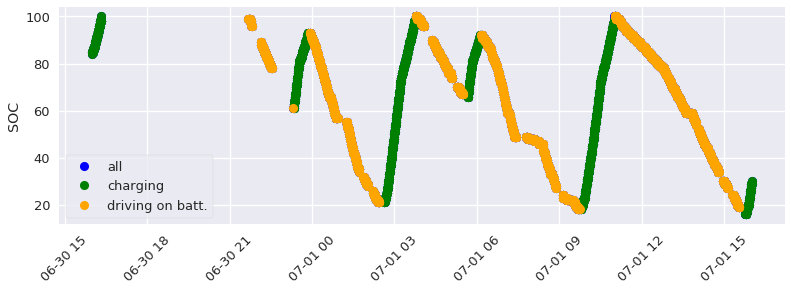

In [6]:
sns.set(rc={"figure.figsize": (13, 4)})
sns.set_context('talk')


f, (ax) = plt.subplots()

ax.plot(ts['veh_soc'], 'bo', label='all')
#ax.plot(ts_drive['veh_soc'], 'ro', label='driving')
ax.plot(ts_charge['veh_soc'], 'go', label='charging')
ax.plot(ts_drive_on_batt['veh_soc'], 'o', color='orange', label='driving on batt.')
#ax.plot(ts2['veh_soc'], 'ro')

ax.legend(loc=0, frameon=True)
ax.set_ylabel('SOC')
plt.xticks(rotation=45)
sns.despine()

# Trips and charging periods

In [7]:
flow.battery_periods()

/home/trangel/guobiao-v4/veh.zip/trip_based_stats/find_periods.py:50: FutureWarning: 'ts' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Found 5 driving periods
Found 6 charging periods
Found 2 charging full-soc periods
Found 3 trips full-soc


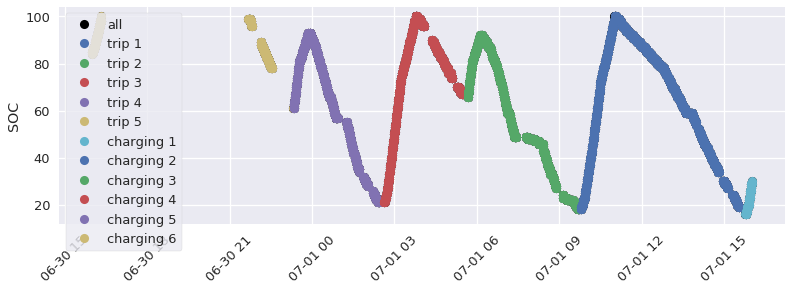

In [8]:
sns.set(rc={"figure.figsize": (13, 4)})
sns.set_context('talk')


f, (ax) = plt.subplots()

ax.plot(ts['veh_soc'], 'o', color='black', label='all')
for i, df in enumerate(flow.trips_on_battery):
    ax.plot(df['veh_soc'], 'o', label='trip {}'.format(i+1))
      
for i, df in enumerate(flow.charging_periods):
    ax.plot(df['veh_soc'], 'o',  label='charging {}'.format(i+1))

ax.legend(loc=2, frameon=True)
ax.set_ylabel('SOC')
plt.xticks(rotation=45)
sns.despine()

# Trips and charging full SOC

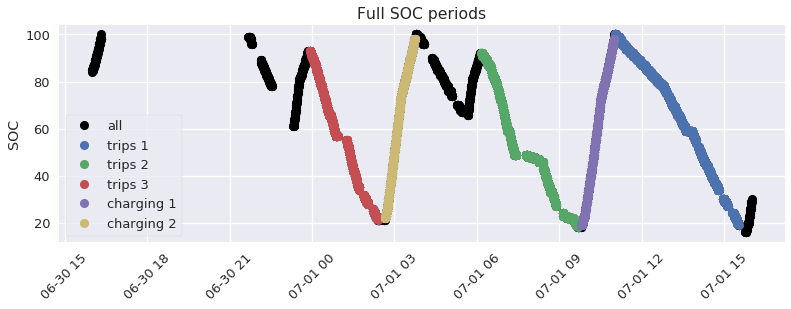

In [9]:
sns.set(rc={"figure.figsize": (13, 4)})
sns.set_context('talk')


f, (ax) = plt.subplots()

ax.plot(ts['veh_soc'], 'o', color='black', label='all')
for i, df in enumerate(flow.trips_full_soc):
    ax.plot(df['veh_soc'], 'o', label='trips {}'.format(i+1))
for i, df in enumerate(flow.charging_full_soc_periods):
    ax.plot(df['veh_soc'], 'o',  label='charging {}'.format(i+1))

ax.set_title('Full SOC periods')
ax.legend(loc=0, frameon=True)
ax.set_ylabel('SOC')
plt.xticks(rotation=45)
sns.despine()

# Statistics   

In [12]:
# which stats = 1: charging, 2: charging full-soc, 3: driving, 4: driving full-soc, 5: polarization
stats = flow.get_battery_stats(which_stats=2)
stats = pd.DataFrame(stats)
print('Stats for {}\n{}'.format(vin, ' '.join(stats.columns)))
print(len(stats.columns))

# Select some columns to visualize
#stats[['day', 'normalized_ah_consumption', 'start_time', 'end_time', 'normalized_kwh_consumption', 'odometer_offset', 'count_records', 'duration', 'delta_soc']].head()#
#stats[['day', 'normalized_ah_throughput', 'normalized_kwh_throughput', 'start_time', 'end_time', 'count_records', 'duration', 'delta_soc']].head()
stats[['day', 'start_soc', 'end_soc', 'ah_throughput', 'delta_soc']]

/usr/lib64/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Stats for LMGHP1S86H1000043
ah_throughput battery_temp_avg battery_temp_max battery_temp_min cell_volt_avg_mean cell_volt_avg_p1 cell_volt_avg_p99 cell_volt_avg_std cell_volt_diff_mean cell_volt_diff_p1 cell_volt_diff_p99 cell_volt_diff_std count_records day delta_soc duration end_soc end_time kwh_throughput normalized_ah_throughput normalized_duration normalized_kwh_throughput start_soc start_time veh_curr_mean veh_curr_p1 veh_curr_p99 veh_curr_std
28


,day,start_soc,end_soc,ah_throughput,delta_soc
0,2018-07-01,19,98,94.334504,79
1,2018-07-01,22,98,91.076423,76


In [11]:
import trip_based_stats.battery_stats as battery_stats
import common.missing_data as md

def print_ct(x):
    print( 'Ah charged {}, discharged {}, throughput {}, consumption {}'.format(x[0], x[1], x[2], x[3]))
    y = x / delta_soc * 100
    print( 'Normalized Ah charged {}, discharged {}, throughput {}, consumption {}'.format(y[0], y[1], y[2], y[3]))

    
period_index = 5
#df = flow.charging_full_soc_periods[period_index]
df = flow.charging_periods[period_index]
#df = flow.trips_full_soc[period_index]
# Make sure stats above is for charging_full_soc or trips_full_soc, consistent with this
delta_soc = np.absolute(stats.loc[period_index, 'delta_soc'])


# For trips
#negative_slope=True
#slope_limit = -0.0005
# For charging
negative_slope=False
slope_limit = 0.001

cols = ['ts', 'veh_curr', 'veh_volt', 'veh_soc']
df2 = df[cols].copy()

# Remove 0.0 entries
df2 = df2.query('veh_curr != 0').copy()

printmd('# vin {}, day {}'.format(vin, day))
printmd('## No corrections')
printmd('** Integration by sum, without correction **')
x_by_sum = battery_stats.get_energy_n_capacity_bysum(df2, option=4)
print_ct(x_by_sum)

printmd('## Compensating missing SOC')
printmd('** Integration by sum, compensate missing SOC **')
compensated = md.compensate_missing_soc(df2['veh_soc'], x_by_sum)
print_ct(compensated)
          
printmd('## Compensating missing time with fixed offset of 120s')
df3 = md.treat_missing_data(df2, offset_seconds=120,
slope_limit=slope_limit, negative_slope=negative_slope)
real_duration = df3.index[-1]
data_duration = len(df2) * 10
# Note df3 has corrected time index, df2 is the original dataset without corrections
print('Total duration {}s with missing time (jumps) {}s'.format(real_duration, real_duration - data_duration))          

printmd('** Integration by sum, compensate missing time, fixed offset **')
compensated = md.compensate_missing_data(real_duration, data_duration, x_by_sum)
print_ct(compensated)
printmd('** Integration by quadrature and interpolate missing data, fixed offset **')
x_by_int = battery_stats.get_energy_n_capacity(df3, option=4)
print_ct(x_by_int)

printmd('## Compensating missing time with current-dependent threshold')
df3 = md.treat_missing_data_current_dependent_threshold(df2, threshold_factor=2.5,
        negative_slope=negative_slope)

real_duration = df3.index[-1]
data_duration = len(df2) * 10
# Note df3 has corrected time index, df2 is the original dataset without corrections
print('Total duration {}s with missing time (jumps) {}s'.format(real_duration, real_duration - data_duration))          

printmd('** Integration by sum, compensate missing time, current-dependent threshold **')
compensated = md.compensate_missing_data(real_duration, data_duration, x_by_sum)

print_ct(compensated)
printmd('** Integration by quadrature and interpolate missing data, current-dependent threshold **')
x_by_int = battery_stats.get_energy_n_capacity(df3, option=4)
print_ct(x_by_int)



KeyError: u'the label [5] is not in the [index]'

In [ ]:
sns.set(rc={"figure.figsize": (15, 7)})
sns.set_context('talk')

df2['power'] = df2['veh_curr'] * df2['veh_volt']


fig, ax = plt.subplots(3)

ax[0].plot(df2['power'], 'o-')
ax[1].plot(df2['veh_curr'], 'o-')
ax[2].plot(df2['veh_volt'], 'o-')


ax[0].set_ylabel('Power (W)')
ax[1].set_ylabel('Current (A)')
ax[2].set_ylabel('Voltage (V)')

plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)

sns.despine()


In [ ]:
sns.set(rc={"figure.figsize": (15, 7)})
sns.set_context('talk')

df3['power'] = df3['veh_curr'] * df3['veh_volt']


fig, ax = plt.subplots(3)

ax[0].plot(df3['power'], 'o-')
ax[1].plot(df3['veh_curr'], 'o-')
ax[2].plot(df3['veh_volt'], 'o-')


ax[0].set_ylabel('Power (W)')
ax[1].set_ylabel('Current (A)')
ax[2].set_ylabel('Voltage (V)')

plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)

sns.despine()

In [ ]:
# Close session
sc.stop()

In [ ]:
df3.iloc[:3].veh_soc